# VAD ET architecture evaluation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import soundfile as sf
import pickle
from copy import copy
import torch
from vad_et import VadET
from vad_set import VadSET

In [2]:
# load the model
model = VadET(input_dim=296, hidden_dim=64, num_layers=2, out_dim=3)
model.load_state_dict(torch.load('models/trained_models/vad_et.pt'))

<All keys matched successfully>

In [99]:
#FILE = '1_flac/rev1-251-137823-0013_3853-163249-0030_777-126732-0056'
FILE = '0_flac/rev1-118-47824-0044_1553-140047-0008_5049-25947-0008'
with np.load('../data/features_old/pvad/test/' + FILE + '.pvad.fea.npz') as f:
    x = f['x']
    embed = f['embed']
    y = f['y']
    #scores = f['scores']
    #x = np.hstack((x, np.expand_dims(scores, 1)))
    x = np.hstack((x, np.full((x.shape[0], 256), embed)))

audio, sr = sf.read('../data/concat_train_clean_100/' + FILE + '.flac')

new_y = np.kron(y, np.ones(160))
new_x = np.kron(x[:,0] + x[:,1], np.ones(160))

In [100]:
# get the model to generate a label vector for us

conv_filter = np.array([1/8]*8)
conv_filter2 = np.cos([1, 0, -1, 0])

with torch.no_grad():
    x_torch = torch.nn.utils.rnn.pack_padded_sequence(torch.unsqueeze(torch.from_numpy(x).float(), 0),
                                                      torch.tensor([y.size]), batch_first=True)
    
   # y_frame = np.array([])
   # for frame in torch.from_numpy(x).float():
   #     frame_packed = torch.unsqueeze(torch.unsqueeze(frame, 0), 0)
   #     frame_packed = torch.nn.utils.rnn.pack_padded_sequence(frame_packed, torch.tensor([1]), batch_first=True)
   #     out_frame = torch.squeeze(model(frame_packed))
   #     y_frame = np.append(y, torch.argmax(out).numpy())
    
    softmax = torch.nn.Softmax(dim=1)
    output_raw = torch.squeeze(model(x_torch))
    output = torch.argmax(output_raw, dim=1)
    output_raw = softmax(output_raw).numpy()
    o0 = np.kron(output_raw[:, 0], np.ones(160))
    o1 = np.kron(output_raw[:, 1], np.ones(160))
    o2 = np.kron(output_raw[:, 2], np.ones(160))
    
    #output_hard = output_raw > 0.5
    ##output_conv = np.convolve(output_raw, conv_filter)
    #output_conv = np.convolve(np.convolve(output_raw, conv_filter), conv_filter2)
    #output_conv_hard = output_conv > 0.5
    o_raw = np.kron(output, np.ones(160))
    #o_hard = np.kron(output_hard, np.ones(160))
    #o_smooth = np.kron(replace_zero_sequences(output_hard, 8), np.ones(160))
    #o_conv = np.kron(output_conv, np.ones(160))

In [101]:
def medfilt (x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
    return np.median (y, axis=1)

filtered = np.kron(medfilt(output.numpy(), 51), np.ones(160))

Text(0.5, 1.0, 'pravděpodobnost TSS')

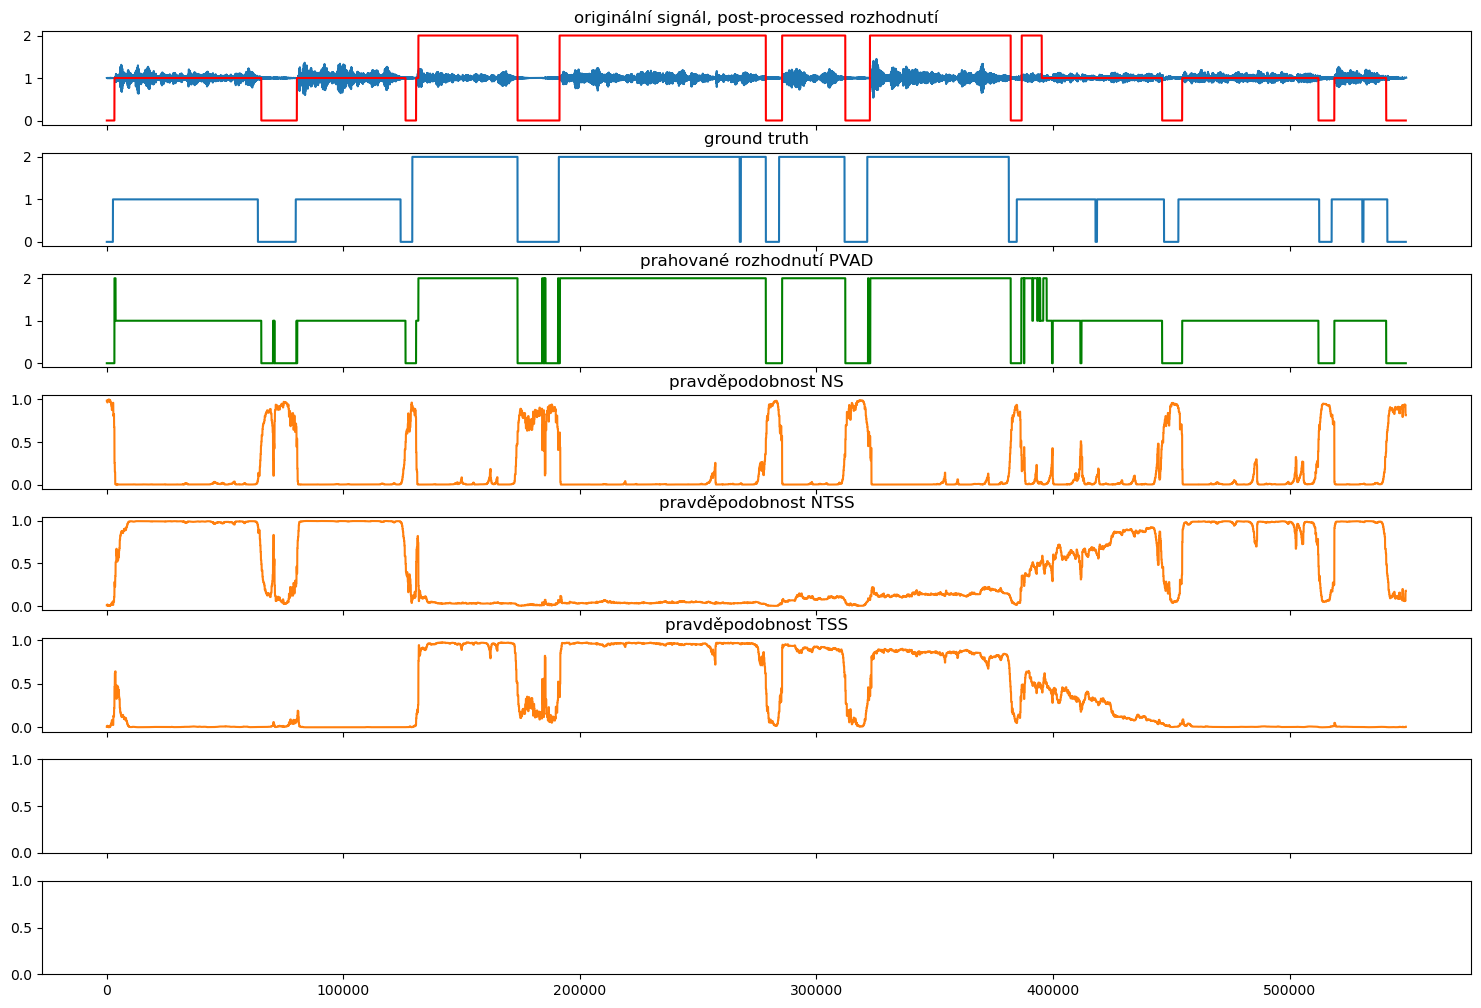

In [102]:
# Plot the original signal and labels plus the first two filterbank coefficients,
# the original shortest sequence and the edited label vector
mpl.style.use('default')
fig, ax = plt.subplots(8, 1, figsize=(15,10), sharex=True)
fig.tight_layout(pad=1.0)

ax[0].plot(audio + 1)
ax[1].plot(new_y)
##ax[2].plot(new_x)
##ax[3].plot(seq)  # plot the position of the shortest sequence
##ax[2].plot(np.kron(replace_zero_sequences(y, 13), np.ones(160))) # deleted super short sequences
ax[2].plot(o_raw, 'green') # plot the vad prediction
ax[3].plot(o0, 'C1') # plot the vad hard thresholded decision
ax[4].plot(o1, 'C1') # plot the vad hard thresholded decision with short sequences removed
ax[5].plot(o2, 'C1') # plot the vad filtered decision
ax[0].plot(medfilt(filtered, 51), 'red') # filtered, thresholded

ax[0].set_title('originální signál, post-processed rozhodnutí')
ax[1].set_title('ground truth')
ax[2].set_title('prahované rozhodnutí PVAD')
ax[3].set_title('pravděpodobnost NS')
ax[4].set_title('pravděpodobnost NTSS')
ax[5].set_title('pravděpodobnost TSS')

## mAP evaluation

In [12]:
# first, load the testing dataset and prepare the testing loop
from vad_et import VadETDataset, VadETDatasetArk, pad_collate, WPL
from vad_set import VadSET, VadSETDatasetArk, VadSETDataset
from vad_st import VadST, VadSTDatasetArk, VadSTDataset
from vad_xvector import VadETDatasetArkX
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.metrics import average_precision_score, confusion_matrix
import kaldiio
import os
USE_KALDI = True

In [19]:
# load the evaluated model and create the corresponding dataset object
arch = 'et'
score_type = 2
batch_size_test = 64
test_dir = '/home/pirx/Devel/bp/personalVAD/data/train_dir/'
os.chdir(test_dir)

if arch == 'et':
    model = VadET(input_dim=296, hidden_dim=64, num_layers=2, out_dim=3)
    model.load_state_dict(torch.load('models/vad_et_10ep_lrelu.pt'))
    if USE_KALDI:
        test_data = VadETDatasetArk('data/test_clean', 'embeddings')
    else:
        test_data = VadETDataset('../data/features/pvad/test')

elif arch == 'set':
    model = VadSET(input_dim=297, hidden_dim=64, num_layers=2, out_dim=3)
    model.load_state_dict(torch.load('models/vad_set_10ep_twohundredk_8454.pt'))
    if USE_KALDI:
        test_data = VadSETDatasetArk('data/test', 'embeddings', score_type)
    else:
        test_data = VadSETDataset('../data/features/pvad/test')

elif arch == 'st':
    model = VadST(input_dim=41, hidden_dim=64, num_layers=2, out_dim=3)
    model.load_state_dict(torch.load('models/vad_st_6ep_twohundredk_score2_8603.pt'))
    if USE_KALDI:
        test_data = VadSTDatasetArk('data/test', score_type)
    else:
        test_data = VadSTDataset('../data/features/pvad/test')
        
elif arch == 'xv':
    model = VadET(input_dim=552, hidden_dim=64, num_layers=2, out_dim=3)
    model.load_state_dict(torch.load('models/vad_et_7ep_xvec.pt'))
    if USE_KALDI:
        test_data = VadETDatasetArkX('data/test_clean', 'embeddings_xvec')
    else:
        test_data = VadETDataset('../data/features/pvad/test')
    
else:
    # we should not get here
    model = None
    pass

test_loader = DataLoader(
        dataset=test_data, batch_size=batch_size_test, num_workers=2, shuffle=False, collate_fn=pad_collate)

In [20]:
# set the device to cuda and move the model to the gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [5]:
# normal evaluation
#with torch.no_grad():
#    print("testing...")
#    n_correct = 0
#    n_samples = 0
#    for x_padded, y_padded, x_lens, y_lens in test_loader:
#        # pad the sequences..
#        x_packed = pack_padded_sequence(
#                x_padded, x_lens, batch_first=True, enforce_sorted=False).to(device)
#
#        out_padded = model(x_packed)
#        y_padded = y_padded.to(device)
#
#        # value, index
#        for j in range(out_padded.size(0)):
#            classes = torch.argmax(out_padded[j][:y_lens[j]], dim=1)
#            n_samples += y_lens[j]
#            n_correct += torch.sum(classes == y_padded[j][:y_lens[j]]).item()
#
#    acc = 100.0 * n_correct / n_samples
#    print(f"correctly classified = {acc:.2f}")

In [31]:
# mAP evaluation
softmax = torch.nn.Softmax(dim=1)
sigmoid = torch.nn.Sigmoid()
targets = []
outputs = []

weights = torch.tensor([1.0, 0.1, 1.0]).to(device)
criterion = WPL(weights)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for x_padded, y_padded, x_lens, y_lens in test_loader:
        y_padded = y_padded.to(device)

        # pass the data through the model
        out_padded, _ = model(x_padded.to(device), x_lens, None)

        # value, index
        for j in range(out_padded.size(0)):
            #loss = criterion(out_padded[j][:y_lens[j]], y_padded[j][:y_lens[j]])
            #print(loss)
            #break
            
            p = softmax(out_padded[j][:y_lens[j]])
            
            outputs.append(p.cpu().numpy())
            targets.append(y_padded[j][:y_lens[j]].cpu().numpy())
                
targets = np.concatenate(targets)
outputs = np.concatenate(outputs)
print(targets.shape)
print(outputs.shape)

/home/pirx/Devel/bp/personalVAD/src/vad_et.py:85: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  y = torch.from_numpy(y).long()
/home/pirx/Devel/bp/personalVAD/src/vad_et.py:85: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pyt

(7575583,)
(7575583, 3)


In [32]:
# convert the target array to one hot
targets_oh = np.eye(3)[targets]

# and run the AP
out_AP = average_precision_score(targets_oh, outputs, average=None)
mAP = average_precision_score(targets_oh, outputs, average='micro')

print(out_AP) 
print(f"mAP: {mAP}")

[0.93231119 0.93799059 0.9305745 ]
mAP: 0.9343824225655528


In [26]:
classes = np.argmax(outputs, axis=1)
confusion_matrix(classes, targets)

from sklearn.metrics import precision_score

precision_score(classes, targets, average='weighted')

0.8682030771658458

## Baseline VAD evaluation

In [13]:
from vad import Vad, VadDataset, VadDatasetArk

In [14]:
model = Vad(input_dim=40, hidden_dim=64, num_layers=2)
model.load_state_dict(torch.load('models/vad_10ep_twohundredk_9426.pt'))
if USE_KALDI:
    test_data = VadDatasetArk('data/test')
else:
    test_data = VadDataset('../data/features/vad/test')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

test_loader = DataLoader(
        dataset=test_data, batch_size=batch_size_test, num_workers=2, shuffle=False, collate_fn=pad_collate)

In [15]:
# mAP evaluation
softmax = torch.nn.Softmax(dim=1)
targets = []
outputs = []

with torch.no_grad():
    for x_padded, y_padded, x_lens, y_lens in test_loader:
        y_padded = y_padded.to(device)

        # pass the data through the model
        out_padded, _ = model(x_padded.to(device), x_lens, None)

        # value, index
        for j in range(out_padded.size(0)):
            p = out_padded[j][:y_lens[j]]
            
            outputs.append(p.cpu().numpy())
            targets.append(y_padded[j][:y_lens[j]].cpu().numpy())
                
targets = np.concatenate(targets)
outputs = np.concatenate(outputs)
print(targets.shape)
print(outputs.shape)

/home/pirx/Devel/bp/personalVAD/src/vad.py:68: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  x = torch.from_numpy(x).float()
/home/pirx/Devel/bp/personalVAD/src/vad.py:68: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/

(30302332,)
(30302332, 1)


In [59]:
# convert the target array to one hot
targets_oh = np.eye(2)[targets.astype(int)]
outputs_oh = np.hstack((1 - outputs, outputs))

# and run the AP
out_AP = average_precision_score(targets_oh, outputs_oh, average=None)
mAP = average_precision_score(targets_oh, outputs_oh, average='weighted')

print(out_AP) 
print(f"mAP: {mAP}")

[0.93522009 0.99715725]
mAP: 0.9861163056321663


# Baseline system

In [25]:
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
class BaselineDataset(Dataset):
    """VadST training dataset. Uses kaldi scp and ark files."""

    def __init__(self, root_dir, score_type):
        self.root_dir = root_dir
        self.score_type = score_type

        self.fbanks = kaldiio.load_scp(f'{self.root_dir}/fbanks.scp')
        self.scores = kaldiio.load_scp(f'{self.root_dir}/scores.scp')
        self.labels = kaldiio.load_scp(f'{self.root_dir}/labels.scp')
        self.keys = np.array(list(self.fbanks)) # get all the keys

    def __len__(self):
        return self.keys.size

    def __getitem__(self, idx):
        key = self.keys[idx]
        x = self.fbanks[key]
        scores = self.scores[key][self.score_type,:]
        y = self.labels[key]

        x = torch.from_numpy(x).float()
        scores = torch.from_numpy(scores).float()
        y = torch.from_numpy(y).long()
        return x, scores, y

def baseline_pad_collate(batch):
    """Padding function used to deal with batches of sequences of variable lengths.

    Returns:
        tuple: A tuple containing:
            
            xx_pad (torch.tensor): Padded feature vector.
            yy_pad (torch.tensor): Padded ground truth vector.
            x_lens (torch.tensor): Lengths of the original feature vectors within the batch.
            y_lens (torch.tensor): Lengths of the original ground truth vectors within the batch.

    """

    (xx, scores, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

    return xx_pad, yy_pad, scores, x_lens, y_lens

In [27]:
model = Vad(input_dim=40, hidden_dim=64, num_layers=2)
model.load_state_dict(torch.load('models/vad_10ep_twohundredk_9426.pt'))
test_data = BaselineDataset('data/test_clean', 0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

test_loader = DataLoader(
        dataset=test_data, batch_size=batch_size_test, num_workers=2, shuffle=False, collate_fn=baseline_pad_collate)

In [30]:
# mAP evaluation
softmax = torch.nn.Softmax(dim=1)
targets = []
outputs = []

with torch.no_grad():
    for x_padded, y_padded, scores, x_lens, y_lens in test_loader:
        y_padded = y_padded.to(device)

        # pass the data through the model
        out_padded, _ = model(x_padded.to(device), x_lens, None)

        # value, index
        for j in range(out_padded.size(0)):
            score = scores[j]
            x = out_padded[j][:y_lens[j]].cpu().squeeze()
            
            # now combine the scores with the vad probability to obtain class probabilities
            ns = 1 - x
            ntss = x * (1 - score)
            tss = x * score
            
            out = torch.stack((ns, ntss, tss)).T
            out = softmax(out)
            outputs.append(out.numpy())
            targets.append(y_padded[j][:y_lens[j]].cpu().numpy())
                
targets = np.concatenate(targets)
outputs = np.concatenate(outputs)
print(targets.shape)
print(outputs.shape)

<ipython-input-25-f8d7f62ebf7e>:24: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  x = torch.from_numpy(x).float()
<ipython-input-25-f8d7f62ebf7e>:24: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tenso

(7575583,)
(7575583, 3)


In [31]:
# convert the target array to one hot
targets_oh = np.eye(3)[targets]

# and run the AP
out_AP = average_precision_score(targets_oh, outputs, average=None)
mAP = average_precision_score(targets_oh, outputs, average='micro')

print(out_AP) 
print(f"mAP: {mAP}")

[0.93471968 0.84227971 0.85994073]
mAP: 0.8173379803525117
